In [1]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

#define the number of clusters
n_cms_ip_cluster = 20

In [3]:
ls

DE1_0_2008_to_2010_Inpatient_Claims_NoHCPCS_Sample_1.csv
Demo-CMS-IP-Analysis.ipynb
Demo-CMS-IP-DataPrep.ipynb
ICD9_DX_CD_Mappings.csv
ICD9_PRCDR_CD_Mappings.csv
cms_ip_tsne_cluster_output.csv
rfout_cms_ip.csv


In [2]:
feature_data = pd.read_csv('Demo_CMS_IP_features_columns_5\000.csv')

ValueError: stat: embedded null character in path

In [3]:
feature_data.dtypes
feature_data.head(3)

DESYNPUF_ID                        object
CLM_ID                              int64
SEGMENT                             int64
CLM_FROM_DT                        object
CLM_THRU_DT                        object
PRVDR_NUM                          object
CLM_PMT_AMT                       float64
NCH_PRMRY_PYR_CLM_PD_AMT          float64
AT_PHYSN_NPI                      float64
OP_PHYSN_NPI                      float64
OT_PHYSN_NPI                      float64
CLM_ADMSN_DT                       object
ADMTNG_ICD9_DGNS_CD                object
CLM_PASS_THRU_PER_DIEM_AMT        float64
NCH_BENE_IP_DDCTBL_AMT            float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM    float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    float64
CLM_UTLZTN_DAY_CNT                  int64
NCH_BENE_DSCHRG_DT                  int64
CLM_DRG_CD                         object
ICD9_DGNS_CD_1                     object
ICD9_DGNS_CD_2                     object
ICD9_DGNS_CD_3                     object
ICD9_DGNS_CD_4                    

DESYNPUF_ID           CLM_ID  SEGMENT CLM_FROM_DT CLM_THRU_DT  \
0  00013D2EFD8E45D1  196661176988405        1  2010-03-12  2010-03-13   
1  00016F745862898F  196201177000368        1  2009-04-12  2009-04-18   
2  00016F745862898F  196661177015632        1  2009-08-31  2009-09-02   

  PRVDR_NUM  CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  AT_PHYSN_NPI  \
0    2600GD       4000.0                       0.0  3.139084e+09   
1    3900MB      26000.0                       0.0  6.476809e+09   
2    3900HM       5000.0                       0.0  6.119985e+08   

   OP_PHYSN_NPI      ...        MEDREIMB_IP BENRES_IP PPPYMT_IP  MEDREIMB_OP  \
0           NaN      ...                0.0       0.0       0.0         50.0   
1           NaN      ...                0.0       0.0       0.0          0.0   
2   611998537.0      ...                0.0       0.0       0.0          0.0   

   BENRES_OP  PPPYMT_OP  MEDREIMB_CAR  BENRES_CAR  PPPYMT_CAR BENE_Age_Group  
0       10.0        0.0           0.0         0.0         0.0            4.0  
1        0.0        0.0         700.0       240.0         0.0            3.0  
2        0.0        0.0         700.0       240.0         0.0            3.0  

[3 rows x 549 columns]

In [4]:
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT','PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_SEX_IDENT_CD','BENE_RACE_CD','BENE_ESRD_IND', 'BENE_COUNTY_CD', 'SP_STATE_CODE',
                  'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

In [5]:
feature_data.describe(include='all')
#data['ICD9_DGNS_CD_1'].head(10)
#data['ICD9_PRCDR_CD_1'].head(10)


DESYNPUF_ID        CLM_ID  SEGMENT CLM_FROM_DT CLM_THRU_DT  \
count               1997  1.997000e+03   1997.0        1997        1997   
unique              1114           NaN      NaN         883         872   
top     019E4729585EF3DD           NaN      NaN  2008-09-09  2008-12-21   
freq                  11           NaN      NaN           8           8   
mean                 NaN  1.964943e+14      1.0         NaN         NaN   
std                  NaN  2.882598e+11      0.0         NaN         NaN   
min                  NaN  1.960112e+14      1.0         NaN         NaN   
25%                  NaN  1.962412e+14      1.0         NaN         NaN   
50%                  NaN  1.964812e+14      1.0         NaN         NaN   
75%                  NaN  1.967412e+14      1.0         NaN         NaN   
max                  NaN  1.969912e+14      1.0         NaN         NaN   

       PRVDR_NUM   CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  AT_PHYSN_NPI  \
count       1997   1997.000000               1997.000000  1.987000e+03   
unique       848           NaN                       NaN           NaN   
top       23006G           NaN                       NaN           NaN   
freq          30           NaN                       NaN           NaN   
mean         NaN   9601.246870                336.654982  4.978398e+09   
std          NaN   9510.744293               2903.211274  2.912672e+09   
min          NaN   -200.000000                  0.000000  5.143392e+06   
25%          NaN   4000.000000                  0.000000  2.441656e+09   
50%          NaN   7000.000000                  0.000000  4.850575e+09   
75%          NaN  11000.000000                  0.000000  7.545022e+09   
max          NaN  57000.000000              58000.000000  9.973493e+09   

        OP_PHYSN_NPI      ...          MEDREIMB_IP     BENRES_IP  \
count   1.153000e+03      ...          1997.000000   1997.000000   
unique           NaN      ...                  NaN           NaN   
top              NaN      ...                  NaN           NaN   
freq             NaN      ...                  NaN           NaN   
mean    5.074268e+09      ...         13010.450676   1401.425138   
std     2.949670e+09      ...         18474.789473   2044.466302   
min     9.720265e+06      ...             0.000000      0.000000   
25%     2.482526e+09      ...             0.000000      0.000000   
50%     4.910218e+09      ...          5000.000000   1024.000000   
75%     7.612966e+09      ...         19030.000000   2048.000000   
max     9.999035e+09      ...        127260.000000  28072.000000   

           PPPYMT_IP   MEDREIMB_OP    BENRES_OP    PPPYMT_OP  MEDREIMB_CAR  \
count    1997.000000   1997.000000  1997.000000  1997.000000   1997.000000   
unique           NaN           NaN          NaN          NaN           NaN   
top              NaN           NaN          NaN          NaN           NaN   
freq             NaN           NaN          NaN          NaN           NaN   
mean      490.736104   1399.714572   476.549825    88.768152   2925.688533   
std      3241.690365   2850.501497   845.002380   663.741056   2567.117952   
min         0.000000      0.000000     0.000000     0.000000      0.000000   
25%         0.000000     90.000000    20.000000     0.000000   1110.000000   
50%         0.000000    500.000000   190.000000     0.000000   2400.000000   
75%         0.000000   1630.000000   580.000000     0.000000   4000.000000   
max     58000.000000  36400.000000  9810.000000  9000.000000  20280.000000   

         BENRES_CAR   PPPYMT_CAR BENE_Age_Group  
count   1997.000000  1997.000000    1997.000000  
unique          NaN          NaN            NaN  
top             NaN          NaN            NaN  
freq            NaN          NaN            NaN  
mean     790.746119    44.331497       3.652979  
std      644.603616   151.864551       0.776184  
min        0.000000     0.000000       1.000000  
25%      330.000000     0.000000       3.000000  
50%      700.000000

In [6]:
#feature_data.Other_proc.value_counts()

In [7]:
# Scale KPIs

KPI_COLUMNS = ['CLM_PMT_AMT']    
SCALED_KPI_COLUMNS = ['SCALED_CLM_PMT_AMT']
#scaler = RobustScaler(quantile_range=(25, 75))
scaler = MinMaxScaler()
scaled_kpi_data = pd.DataFrame(scaler.fit_transform(feature_data[KPI_COLUMNS]), columns=SCALED_KPI_COLUMNS)
scaled_kpi_data.head(10)

SCALED_CLM_PMT_AMT
0            0.073427
1            0.458042
2            0.090909
3            0.090909
4            0.283217
5            0.248252
6            0.090909
7            0.090909
8            0.248252
9            0.510490

In [8]:
# Create "Orig Cluster Data" with all original KPIs

orig_cluster_data = feature_data.drop(EXCLUDE_COLUMNS, axis=1)

scaled_cluster_data = orig_cluster_data

In [9]:
# Create "Cluster Data" with scaled KPIs
a = orig_cluster_data.copy()
b = scaled_kpi_data.copy()
a.reset_index(drop=True, inplace=True)
b.reset_index(drop=True, inplace=True)
scaled_cluster_data = pd.concat([a,b], axis=1)
scaled_cluster_data.head(3)
scaled_cluster_data.dtypes

CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  CLM_PASS_THRU_PER_DIEM_AMT  \
0       4000.0                       0.0                         0.0   
1      26000.0                       0.0                         0.0   
2       5000.0                       0.0                         0.0   

   NCH_BENE_IP_DDCTBL_AMT  NCH_BENE_PTA_COINSRNC_LBLTY_AM  \
0                  1100.0                             0.0   
1                  1068.0                             0.0   
2                  1068.0                             0.0   

   NCH_BENE_BLOOD_DDCTBL_LBLTY_AM  CLM_UTLZTN_DAY_CNT  proc_9904  proc_8154  \
0                             0.0                   1          0          0   
1                             0.0                   6          0          0   
2                             0.0                   2          0          0   

   proc_3893         ...          CLM_FROM_Year  CLM_FROM_Month  CLM_FROM_Day  \
0          0         ...                   2010               3            12   
1          0         ...                   2009               4            12   
2          0         ...                   2009               8            31   

   CLM_FROM_DOW  BENE_HI_CVRAGE_TOT_MONS  BENE_SMI_CVRAGE_TOT_MONS  \
0             4                       12                        12   
1             6                       12                        12   
2             0                       12                        12   

   BENE_HMO_CVRAGE_TOT_MONS  PLAN_CVRG_MOS_NUM  BENE_Age_Group  \
0                        12                 12             4.0   
1                         0                  0             3.0   
2                         0                  0             3.0   

   SCALED_CLM_PMT_AMT  
0            0.073427  
1            0.458042  
2            0.090909  

[3 rows x 494 columns]

CLM_PMT_AMT                           float64
NCH_PRMRY_PYR_CLM_PD_AMT              float64
CLM_PASS_THRU_PER_DIEM_AMT            float64
NCH_BENE_IP_DDCTBL_AMT                float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM        float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM        float64
CLM_UTLZTN_DAY_CNT                      int64
proc_9904                               int64
proc_8154                               int64
proc_3893                               int64
proc_66                                 int64
proc_3995                               int64
proc_4516                               int64
proc_3722                               int64
proc_9671                               int64
proc_8872                               int64
proc_8151                               int64
proc_4513                               int64
proc_9390                               int64
proc_9672                               int64
proc_7935                               int64
proc_5123                         

In [10]:
#scaled_cluster_data_cms_ip = scaled_cluster_data.loc[lambda scaled_cluster_data: scaled_cluster_data.cms_ip ==1,:]
scaled_cluster_data_cms_ip = scaled_cluster_data

In [11]:
def cluster_model(n_cluster):
#    model = AgglomerativeClustering(n_clusters=n_cluster,linkage="complete", affinity="cosine")
#    model = AgglomerativeClustering(n_clusters=n_cluster,linkage="complete", affinity="manhattan")
    model = KMeans(n_clusters=n_cluster, random_state=0)
    return model

# cms_ip Cluster

In [12]:
scaled_cluster_data_cms_ip.head(3)

CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  CLM_PASS_THRU_PER_DIEM_AMT  \
0       4000.0                       0.0                         0.0   
1      26000.0                       0.0                         0.0   
2       5000.0                       0.0                         0.0   

   NCH_BENE_IP_DDCTBL_AMT  NCH_BENE_PTA_COINSRNC_LBLTY_AM  \
0                  1100.0                             0.0   
1                  1068.0                             0.0   
2                  1068.0                             0.0   

   NCH_BENE_BLOOD_DDCTBL_LBLTY_AM  CLM_UTLZTN_DAY_CNT  proc_9904  proc_8154  \
0                             0.0                   1          0          0   
1                             0.0                   6          0          0   
2                             0.0                   2          0          0   

   proc_3893         ...          CLM_FROM_Year  CLM_FROM_Month  CLM_FROM_Day  \
0          0         ...                   2010               3            12   
1          0         ...                   2009               4            12   
2          0         ...                   2009               8            31   

   CLM_FROM_DOW  BENE_HI_CVRAGE_TOT_MONS  BENE_SMI_CVRAGE_TOT_MONS  \
0             4                       12                        12   
1             6                       12                        12   
2             0                       12                        12   

   BENE_HMO_CVRAGE_TOT_MONS  PLAN_CVRG_MOS_NUM  BENE_Age_Group  \
0                        12                 12             4.0   
1                         0                  0             3.0   
2                         0                  0             3.0   

   SCALED_CLM_PMT_AMT  
0            0.073427  
1            0.458042  
2            0.090909  

[3 rows x 494 columns]

In [13]:
n_cms_ip_cluster = 20
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT','PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_SEX_IDENT_CD','BENE_RACE_CD','BENE_ESRD_IND', 'BENE_COUNTY_CD', 'SP_STATE_CODE',
                  'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

In [14]:
cms_ip_cluster_output = scaled_cluster_data_cms_ip.copy()
ready_cluster_data_cms_ip = scaled_cluster_data_cms_ip.drop(KPI_INDEX_COLUMNS, axis=1)
X_cms_ip = ready_cluster_data_cms_ip.values
X_cms_ip[0:3,:]
X_cms_ip.shape
#ready_cluster_data_cms_ip.Other_proc.value_counts()
ready_cluster_data_cms_ip.head(3)

array([[ 0.        ,  0.        ,  0.        , ..., 12.        ,
         4.        ,  0.07342657],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.        ,  0.45804196],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.        ,  0.09090909]])

(1997, 477)

proc_9904  proc_8154  proc_3893  proc_66  proc_3995  proc_4516  proc_3722  \
0          0          0          0        0          0          0          0   
1          0          0          0        0          0          0          0   
2          0          0          0        0          0          0          0   

   proc_9671  proc_8872  proc_8151         ...          dx_42841  dx_4439  \
0          0          0          0         ...                 0        0   
1          0          0          0         ...                 0        0   
2          0          0          0         ...                 0        0   

   dx_3843  dx_OTHER_DX  BENE_HI_CVRAGE_TOT_MONS  BENE_SMI_CVRAGE_TOT_MONS  \
0        0            1                       12                        12   
1        0            1                       12                        12   
2        0            1                       12                        12   

   BENE_HMO_CVRAGE_TOT_MONS  PLAN_CVRG_MOS_NUM  BENE_Age_Group  \
0                        12                 12             4.0   
1                         0                  0             3.0   
2                         0                  0             3.0   

   SCALED_CLM_PMT_AMT  
0            0.073427  
1            0.458042  
2            0.090909  

[3 rows x 477 columns]

In [15]:
#cms_ip_cluster_output = scaled_cluster_data_cms_ip.copy()
#ready_cluster_data_cms_ip = scaled_cluster_data_cms_ip.drop(KPI_INDEX_COLUMNS, axis=1)
#X_cms_ip = ready_cluster_data_cms_ip.values
model_cms_ip = cluster_model(n_cms_ip_cluster)
model_cms_ip.fit(X_cms_ip)
label_cms_ip = model_cms_ip.labels_
cms_ip_cluster_output["cluster"] = label_cms_ip
cms_ip_cluster_output.to_csv("cms_ip_cluster_output.csv")

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [16]:
cms_ip_cluster_output["cluster"].value_counts()

2     614
1     388
7     317
17    191
8     180
10    105
3      42
6      27
15     22
19     18
16     17
12     16
0      15
4       9
11      9
9       9
5       6
14      5
13      4
18      3
Name: cluster, dtype: int64

In [17]:
cms_ip_cluster_output.head(1)

CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  CLM_PASS_THRU_PER_DIEM_AMT  \
0       4000.0                       0.0                         0.0   

   NCH_BENE_IP_DDCTBL_AMT  NCH_BENE_PTA_COINSRNC_LBLTY_AM  \
0                  1100.0                             0.0   

   NCH_BENE_BLOOD_DDCTBL_LBLTY_AM  CLM_UTLZTN_DAY_CNT  proc_9904  proc_8154  \
0                             0.0                   1          0          0   

   proc_3893   ...     CLM_FROM_Month  CLM_FROM_Day  CLM_FROM_DOW  \
0          0   ...                  3            12             4   

   BENE_HI_CVRAGE_TOT_MONS  BENE_SMI_CVRAGE_TOT_MONS  \
0                       12                        12   

   BENE_HMO_CVRAGE_TOT_MONS  PLAN_CVRG_MOS_NUM  BENE_Age_Group  \
0                        12                 12             4.0   

   SCALED_CLM_PMT_AMT  cluster  
0            0.073427        1  

[1 rows x 495 columns]

In [18]:
#evaluate clusters
print(metrics.silhouette_score(X_cms_ip, label_cms_ip, metric='euclidean'))
print(metrics.calinski_harabaz_score(X_cms_ip, label_cms_ip))

0.19224260016148512
1337.9213163108484


PCA Visualization

(1997, 3)


[]

[]

[]

Text(0.5,0,u'PCA 1')

Text(0.5,0,u'PCA 2')

Text(0.5,0,u'PCA 3')

Text(0.5,0.92,u'AC clusters on PCA')

(1997, 2)


No handlers could be found for logger "matplotlib.legend"


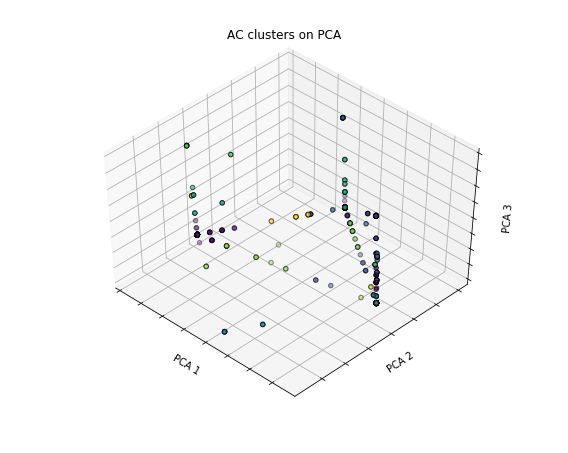

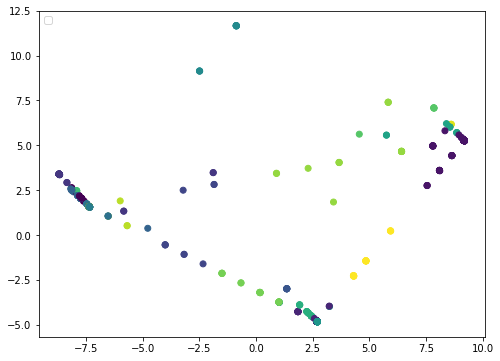

In [19]:
from sklearn import decomposition
# Import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
PC = decomposition.PCA(n_components=3).fit_transform(ready_cluster_data_cms_ip.values)
print(PC.shape)
fig = plt.figure(1, figsize=(8, 6))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
#use the cluster membership as labels
ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2],
               c=label_cms_ip, edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title("AC clusters on PCA")
ax.dist = 12


PC2 = decomposition.PCA(n_components=2).fit_transform(ready_cluster_data_cms_ip.values)
print(PC2.shape)
fig2 = plt.figure(2, figsize=(8, 6))
plt.scatter(PC[:,0],PC[:,1],c=label_cms_ip)
plt.legend(loc=2)


# TSNE Visualization. Reset Kernel

In [20]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

In [34]:
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

EXCLUDE_COLUMNS = ['DESYNPUF_ID','CLM_ID','SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT','PRVDR_NUM', 'AT_PHYSN_NPI','OP_PHYSN_NPI', 'OT_PHYSN_NPI',
                  'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
                  'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
                  'ICD9_PRCDR_CD_1','ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6',
                  'BENE_SEX_IDENT_CD','BENE_RACE_CD','BENE_ESRD_IND', 'BENE_COUNTY_CD', 'SP_STATE_CODE',
                  'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
                  'MEDREIMB_IP','BENRES_IP','PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR', 'PPPYMT_CAR', 'BENRES_CAR']

In [35]:
KPI_INDEX_COLUMNS.append('cluster')
KPI_INDEX_COLUMNS

[u'CLM_PMT_AMT',
 u'NCH_PRMRY_PYR_CLM_PD_AMT',
 u'CLM_PASS_THRU_PER_DIEM_AMT',
 u'NCH_BENE_IP_DDCTBL_AMT',
 u'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_UTLZTN_DAY_CNT',
 u'LOG_CLM_PMT_AMT',
 u'LOG_NCH_PRMRY_PYR_CLM_PD_AMT',
 u'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
 u'LOG_NCH_BENE_IP_DDCTBL_AMT',
 u'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_FROM_Year',
 u'CLM_FROM_Month',
 u'CLM_FROM_Day',
 u'CLM_FROM_DOW',
 u'cluster']

In [36]:
def tsne_viz(tsne_data,KPI_INDEX_COLUMNS):

    Y = tsne_data["cluster"].values
    tsne_data_x = tsne_data.iloc[:,1:]
    X = tsne_data_x.drop(KPI_INDEX_COLUMNS, axis=1).values
    
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne_reduced = tsne.fit_transform(X)
    
    return X_tsne_reduced, Y

# TSNE Visualization: cms_ip Cluster

(-47.50978097615901, 33.046461197716624, -46.34920361289389, 41.54185726889975)

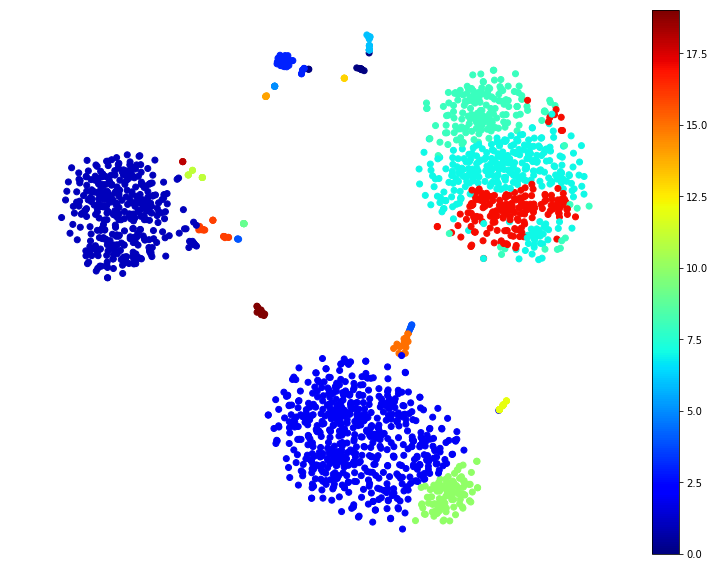

In [37]:
input_file = "cms_ip_cluster_output.csv"

output_file = "cms_ip_tsne_cluster_output.csv"

tsne_cluster_data = pd.read_csv(input_file)
X_pca_tsne_reduced, Y = tsne_viz(tsne_cluster_data,KPI_INDEX_COLUMNS)    

plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1],c=Y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

tsne_cluster_data['TSNE1'] = X_pca_tsne_reduced[:, 0]
tsne_cluster_data['TSNE2'] = X_pca_tsne_reduced[:, 1]
tsne_cluster_data.to_csv(output_file)

# Random Forest Explanation

# Reset Kernel

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

#define the number of clusters
n_cms_ip_cluster = 20

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------------------------
H2O cluster uptime:         09 secs
H2O cluster timezone:       America/Los_Angeles
H2O data parsing timezone:  UTC
H2O cluster version:        3.18.0.2
H2O cluster version age:    6 months and 19 days !!!
H2O cluster name:           H2O_from_python_prashanthkini_25n0oq
H2O cluster total nodes:    1
H2O cluster free memory:    3.539 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             2.7.14 final
--------------------------  ----------------------------------------

In [4]:
KPI_INDEX_COLUMNS = ['CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
                     'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT', 'LOG_CLM_PMT_AMT', 'LOG_NCH_PRMRY_PYR_CLM_PD_AMT', 'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
                     'LOG_NCH_BENE_IP_DDCTBL_AMT', 'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_FROM_Year', 'CLM_FROM_Month', 'CLM_FROM_Day', 'CLM_FROM_DOW']

In [5]:
KPI_INDEX_COLUMNS.append('cluster')
KPI_INDEX_COLUMNS

[u'CLM_PMT_AMT',
 u'NCH_PRMRY_PYR_CLM_PD_AMT',
 u'CLM_PASS_THRU_PER_DIEM_AMT',
 u'NCH_BENE_IP_DDCTBL_AMT',
 u'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_UTLZTN_DAY_CNT',
 u'LOG_CLM_PMT_AMT',
 u'LOG_NCH_PRMRY_PYR_CLM_PD_AMT',
 u'LOG_CLM_PASS_THRU_PER_DIEM_AMT',
 u'LOG_NCH_BENE_IP_DDCTBL_AMT',
 u'LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM',
 u'LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
 u'CLM_FROM_Year',
 u'CLM_FROM_Month',
 u'CLM_FROM_Day',
 u'CLM_FROM_DOW',
 u'cluster']

# Explanation: cms_ip Clusters. Delete the rfout file.

In [6]:
cluster_cms_ip = pd.read_csv('cms_ip_cluster_output.csv')
cluster_cms_ip_x = cluster_cms_ip.iloc[:,1:]
cluster_cms_ip_predictors = cluster_cms_ip_x.drop(KPI_INDEX_COLUMNS, axis=1)
label_cms_ip = cluster_cms_ip["cluster"].values
ntree=  500
depth = 30
nfold = 10
#tempoutput = pd.DataFrame(columns=['variable','relative_importance','scaled_importance','percentage','cluster_member','data_segment'])
output_file = open('rfout_cms_ip.csv','a')
for i in range(n_cms_ip_cluster):
    rf_cms_ip_model = H2ORandomForestEstimator(ntrees=ntree, max_depth=depth, nfolds=nfold)
    predictors= cluster_cms_ip_predictors.columns.values.tolist()
    response = "cluster"
    classlabels = np.where(label_cms_ip==i,1,0)
    rf_df = h2o.H2OFrame(cluster_cms_ip_predictors)
    rf_df.set_names(predictors)
    rf_df[response]=h2o.H2OFrame(classlabels)
    train,valid = rf_df.split_frame(ratios = [0.8], seed=42)
    rf_cms_ip_model.train(x=predictors,y=response, training_frame = train, validation_frame = valid)
    output_df = rf_cms_ip_model._model_json['output']['variable_importances'].as_data_frame()
    output_df["cluster_member"] = i
    output_df["data_segment"] = "cms_ip"
    output_df
    if i==1:
        output_df.to_csv(output_file, header=True)
    else:
        output_df.to_csv(output_file, header=False)

output_file.close()

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0     BENE_HI_CVRAGE_TOT_MONS          1424.699463           1.000000   
1    BENE_SMI_CVRAGE_TOT_MONS          1070.745483           0.751559   
2           PLAN_CVRG_MOS_NUM           282.705383           0.198432   
3          SCALED_CLM_PMT_AMT            98.033310           0.068810   
4              BENE_Age_Group            89.218727           0.062623   
5                     dx_4019            83.194183           0.058394   
6    BENE_HMO_CVRAGE_TOT_MONS            83.123634           0.058345   
7                    dx_25060            77.756363           0.054577   
8                    dx_29634            62.492893           0.043864   
9                     dx_5119            59.115517           0.041493   
10                   dx_29633            49.646744           0.034847   
11                   dx_53550            43.351345           0.030428   
12                  proc_3613            35.824989           0.025146   
13                   dx_34830            35.750542           0.025093   
14                   dx_40291            29.043674           0.020386   
15                     dx_515            26.224258           0.018407   
16                    dx_4139            25.782219           0.018097   
17                     dx_486            22.827318           0.016023   
18                   dx_57420            22.758224           0.015974   
19                  proc_4523            22.384159           0.015711   
20                   dx_44024            22.171587           0.015562   
21                   dx_34590            20.760670           0.014572   
22                   dx_43889            18.854433           0.013234   
23                    dx_4280            18.203482           0.012777   
24                  proc_3723            16.991667           0.011926   
25                   dx_42731            15.542989           0.010910   
26                    dx_4168            14.226487           0.009986   
27                    dx_2800            11.871481           0.008333   
28                     dx_496            11.512462           0.008081   
29                   proc_131            11.435570           0.008027   
..                        ...                  ...                ...   
408                  dx_78909             0.000000           0.000000   
409                  dx_20500             0.000000           0.000000   
410                   dx_7812             0.000000           0.000000   
411                   dx_6824             0.000000           0.000000   
412                   dx_1889             0.000000           0.000000   
413                  dx_53019             0.000000           0.000000   
414                  dx_29654             0.000000           0.000000   
415                   dx_5959             0.000000           0.000000   
416                   dx_5602             0.000000           0.000000   
417                   dx_4871             0.000000           0.000000   
418                   dx_3962             0.000000           0.000000   
419                   dx_3819             0.000000           0.000000   
420                  dx_99762             0.000000           0.000000   
421                  dx_81201             0.000000           0.000000   
422                  dx_73027             0.000000           0.000000   
423                  dx_30391             0.000000           0.000000   
424                   dx_7847             0.000000           0.000000   
425                   dx_5691             0.000000           0.000000   
426                   dx_4372             0.000000           0.000000   
427                    dx_539             0.000000           0.000000   
428                   dx_V571             0.000000           0.000000   
429                  dx_99644             0.000000           0.000000   
430                  dx_29640             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0    BENE_HMO_CVRAGE_TOT_MONS         80388.148438           1.000000   
1           PLAN_CVRG_MOS_NUM          8072.457520           0.100419   
2     BENE_HI_CVRAGE_TOT_MONS           986.331787           0.012270   
3    BENE_SMI_CVRAGE_TOT_MONS           976.774170           0.012151   
4          SCALED_CLM_PMT_AMT           146.427597           0.001822   
5              BENE_Age_Group           113.456390           0.001411   
6                     dx_8244           107.695152           0.001340   
7                     dx_6822            61.724514           0.000768   
8                     dx_2761            53.682873           0.000668   
9                    dx_29630            47.380836           0.000589   
10                  proc_3491            45.042347           0.000560   
11                   dx_43411            36.045383           0.000448   
12                    dx_5856            35.120667           0.000437   
13                   dx_27801            34.880413           0.000434   
14                   dx_71516            33.487049           0.000417   
15                    dx_1977            33.385849           0.000415   
16                    dx_5693            31.235231           0.000389   
17                    dx_4241            31.140482           0.000387   
18                   dx_40390            31.046570           0.000386   
19            proc_OTHER_PROC            30.907169           0.000384   
20                      dx_42            30.776335           0.000383   
21                    dx_2989            29.876152           0.000372   
22                    dx_4019            29.712317           0.000370   
23                   dx_73313            26.689146           0.000332   
24                  proc_8659            26.604471           0.000331   
25                   dx_41401            26.536665           0.000330   
26                  proc_9904            26.499891           0.000330   
27                    dx_4260            24.267380           0.000302   
28                   dx_34831            23.624498           0.000294   
29                  proc_8051            23.394365           0.000291   
..                        ...                  ...                ...   
408                  dx_78605             0.000000           0.000000   
409                  dx_53541             0.000000           0.000000   
410                  dx_29590             0.000000           0.000000   
411                   dx_9961             0.000000           0.000000   
412                   dx_1830             0.000000           0.000000   
413                   dx_1533             0.000000           0.000000   
414                  dx_33182             0.000000           0.000000   
415                  dx_25062             0.000000           0.000000   
416                   dx_4270             0.000000           0.000000   
417                  dx_78909             0.000000           0.000000   
418                  dx_20500             0.000000           0.000000   
419                  dx_53019             0.000000           0.000000   
420                  dx_29654             0.000000           0.000000   
421                   dx_5959             0.000000           0.000000   
422                   dx_5602             0.000000           0.000000   
423                   dx_4871             0.000000           0.000000   
424                   dx_3819             0.000000           0.000000   
425                  dx_99762             0.000000           0.000000   
426                  dx_81201             0.000000           0.000000   
427                  dx_73027             0.000000           0.000000   
428                   dx_7847             0.000000           0.000000   
429                   dx_5691             0.000000           0.000000   
430                   dx_4372             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0           PLAN_CVRG_MOS_NUM         60988.917969           1.000000   
1    BENE_HMO_CVRAGE_TOT_MONS         35443.421875           0.581145   
2              BENE_Age_Group         13129.720703           0.215280   
3    BENE_SMI_CVRAGE_TOT_MONS          3994.306641           0.065492   
4     BENE_HI_CVRAGE_TOT_MONS           620.703613           0.010177   
5                     dx_2761           130.182083           0.002135   
6          SCALED_CLM_PMT_AMT           106.836487           0.001752   
7                     dx_5856           102.483498           0.001680   
8                    dx_25070            40.342232           0.000661   
9                     dx_4010            34.518333           0.000566   
10                    proc_66            33.648621           0.000552   
11                    dx_4241            32.983391           0.000541   
12                   dx_60001            32.661049           0.000536   
13                   dx_51884            31.076828           0.000510   
14                   dx_42830            29.813929           0.000489   
15                   dx_99662            29.374235           0.000482   
16                   dx_78079            28.026489           0.000460   
17                   dx_70703            27.485981           0.000451   
18                    dx_4168            26.880705           0.000441   
19                  proc_8415            25.285381           0.000415   
20                    dx_2841            25.175089           0.000413   
21                   dx_41400            25.092821           0.000411   
22                   dx_34831            24.158777           0.000396   
23                    dx_5849            24.103735           0.000395   
24                   dx_99812            24.028723           0.000394   
25                    dx_7242            23.065760           0.000378   
26                   dx_42821            22.801807           0.000374   
27                  proc_9390            22.698547           0.000372   
28                   dx_42831            21.632113           0.000355   
29                    dx_5589            21.537617           0.000353   
..                        ...                  ...                ...   
408                   dx_6820             0.000000           0.000000   
409                  dx_42822             0.000000           0.000000   
410                   dx_6185             0.000000           0.000000   
411                   dx_4210             0.000000           0.000000   
412                  dx_78605             0.000000           0.000000   
413                  dx_53541             0.000000           0.000000   
414                   dx_9961             0.000000           0.000000   
415                   dx_5128             0.000000           0.000000   
416                   dx_1830             0.000000           0.000000   
417                   dx_1533             0.000000           0.000000   
418                     dx_42             0.000000           0.000000   
419                   dx_4270             0.000000           0.000000   
420                  dx_20500             0.000000           0.000000   
421                   dx_6824             0.000000           0.000000   
422                  dx_53019             0.000000           0.000000   
423                  dx_29654             0.000000           0.000000   
424                   dx_5959             0.000000           0.000000   
425                   dx_5602             0.000000           0.000000   
426                  dx_99762             0.000000           0.000000   
427                  dx_81201             0.000000           0.000000   
428                   dx_5691             0.000000           0.000000   
429                   dx_4372             0.000000           0.000000   
430                   dx_V571             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0     BENE_HI_CVRAGE_TOT_MONS          7205.704102           1.000000   
1    BENE_SMI_CVRAGE_TOT_MONS          3129.885742           0.434362   
2           PLAN_CVRG_MOS_NUM          1229.944336           0.170690   
3    BENE_HMO_CVRAGE_TOT_MONS           221.823730           0.030784   
4                   proc_6859            61.025013           0.008469   
5                      dx_311            60.104652           0.008341   
6                    dx_28262            54.250912           0.007529   
7              BENE_Age_Group            48.123837           0.006679   
8          SCALED_CLM_PMT_AMT            39.516373           0.005484   
9                    dx_78652            34.084343           0.004730   
10            proc_OTHER_PROC            32.314548           0.004485   
11                    dx_4271            25.723600           0.003570   
12                    dx_7802            15.681858           0.002176   
13                  proc_4516            15.341002           0.002129   
14                    dx_1977            14.544609           0.002018   
15                   dx_27651            13.030237           0.001808   
16                  proc_9465            12.521667           0.001738   
17                  proc_8944            12.492556           0.001734   
18                    proc_66            12.075160           0.001676   
19                    dx_1579            11.296898           0.001568   
20                    dx_7242            11.134040           0.001545   
21                   dx_34831            10.995930           0.001526   
22                  proc_4011            10.627378           0.001475   
23                   dx_70703             9.987505           0.001386   
24                     dx_496             9.706713           0.001347   
25                    dx_4871             8.961876           0.001244   
26                   dx_42731             8.115061           0.001126   
27                   dx_41400             7.354184           0.001021   
28                   dx_56081             6.549577           0.000909   
29                    dx_4580             6.499546           0.000902   
..                        ...                  ...                ...   
408                   dx_4270             0.000000           0.000000   
409                  dx_78909             0.000000           0.000000   
410                  dx_20500             0.000000           0.000000   
411                   dx_7812             0.000000           0.000000   
412                   dx_6824             0.000000           0.000000   
413                   dx_1889             0.000000           0.000000   
414                  dx_53019             0.000000           0.000000   
415                  dx_29654             0.000000           0.000000   
416                   dx_5959             0.000000           0.000000   
417                   dx_5602             0.000000           0.000000   
418                   dx_3962             0.000000           0.000000   
419                   dx_3819             0.000000           0.000000   
420                  dx_99762             0.000000           0.000000   
421                  dx_81201             0.000000           0.000000   
422                  dx_73027             0.000000           0.000000   
423                   dx_7847             0.000000           0.000000   
424                   dx_5691             0.000000           0.000000   
425                   dx_4372             0.000000           0.000000   
426                    dx_539             0.000000           0.000000   
427                   dx_V571             0.000000           0.000000   
428                  dx_99644             0.000000           0.000000   
429                  dx_29640             0.000000           0.000000   
430                   dx_7840             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0           PLAN_CVRG_MOS_NUM           430.916718           1.000000   
1                    dx_85221           235.459381           0.546415   
2                   proc_4131           127.309364           0.295438   
3                     dx_5780           122.082207           0.283308   
4          SCALED_CLM_PMT_AMT           118.291229           0.274511   
5    BENE_HMO_CVRAGE_TOT_MONS           110.865669           0.257279   
6                    dx_42732            99.588615           0.231109   
7                   proc_9929            94.525238           0.219358   
8                     dx_8054            88.218033           0.204722   
9                    dx_42731            81.863327           0.189975   
10                   dx_78097            77.593849           0.180067   
11                   dx_40391            71.573586           0.166096   
12                     dx_486            66.344254           0.153961   
13                    dx_4168            61.691067           0.143162   
14                    dx_4019            60.848392           0.141207   
15                   dx_42830            55.312897           0.128361   
16             BENE_Age_Group            49.374115           0.114579   
17                    dx_2761            43.562359           0.101092   
18                   dx_99664            39.905514           0.092606   
19                   dx_53081            38.006851           0.088200   
20                    dx_5601            34.645302           0.080399   
21                   dx_49322            34.505608           0.080075   
22                   dx_27651            34.180038           0.079319   
23                   dx_42823            32.176044           0.074669   
24                   dx_43491            31.337246           0.072722   
25                    dx_5990            28.850080           0.066950   
26                   dx_71536            26.273855           0.060972   
27                    dx_5856            26.217306           0.060841   
28                    dx_5849            25.691319           0.059620   
29                    dx_2800            24.388824           0.056598   
..                        ...                  ...                ...   
408                   dx_1579             0.000000           0.000000   
409                  dx_78909             0.000000           0.000000   
410                  dx_20500             0.000000           0.000000   
411                   dx_7812             0.000000           0.000000   
412                   dx_6824             0.000000           0.000000   
413                   dx_1889             0.000000           0.000000   
414                  dx_53019             0.000000           0.000000   
415                  dx_29654             0.000000           0.000000   
416                   dx_5959             0.000000           0.000000   
417                   dx_5602             0.000000           0.000000   
418                   dx_4871             0.000000           0.000000   
419                   dx_3962             0.000000           0.000000   
420                   dx_3819             0.000000           0.000000   
421                  dx_99762             0.000000           0.000000   
422                  dx_81201             0.000000           0.000000   
423                  dx_73027             0.000000           0.000000   
424                   dx_7847             0.000000           0.000000   
425                   dx_5691             0.000000           0.000000   
426                   dx_4372             0.000000           0.000000   
427                   dx_V571             0.000000           0.000000   
428                  dx_99644             0.000000           0.000000   
429                  dx_29640             0.000000           0.000000   
430                  dx_28521             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0                      dx_311           139.694565           1.000000   
1     BENE_HI_CVRAGE_TOT_MONS           126.878670           0.908258   
2                     dx_4871            89.227646           0.638734   
3           PLAN_CVRG_MOS_NUM            80.797134           0.578384   
4                     dx_1579            75.437286           0.540016   
5                     dx_1977            67.778831           0.485193   
6    BENE_SMI_CVRAGE_TOT_MONS            66.966286           0.479376   
7                     dx_6823            56.581902           0.405040   
8                     dx_7242            55.976643           0.400707   
9                    proc_331            55.721462           0.398881   
10                   dx_49122            55.282005           0.395735   
11                    dx_1970            43.971336           0.314768   
12         SCALED_CLM_PMT_AMT            42.731091           0.305889   
13                   dx_72252            38.099808           0.272737   
14   BENE_HMO_CVRAGE_TOT_MONS            34.545811           0.247295   
15                   dx_71536            30.456995           0.218026   
16                   dx_V5789            25.720964           0.184123   
17                   dx_49390            23.235533           0.166331   
18                    dx_4254            21.078588           0.150891   
19                   dx_27651            20.240362           0.144890   
20                    dx_2768            18.068878           0.129346   
21                   dx_41400            17.843569           0.127733   
22                    dx_5849            12.654449           0.090587   
23                   dx_42731            11.721629           0.083909   
24                   dx_40390            10.640468           0.076170   
25                    dx_4019             9.833035           0.070390   
26                    dx_5990             9.100759           0.065148   
27                dx_OTHER_DX             8.204267           0.058730   
28             BENE_Age_Group             6.963133           0.049845   
29                    dx_4280             6.079160           0.043518   
..                        ...                  ...                ...   
408                  dx_20500             0.000000           0.000000   
409                   dx_7812             0.000000           0.000000   
410                   dx_6824             0.000000           0.000000   
411                   dx_1889             0.000000           0.000000   
412                  dx_53019             0.000000           0.000000   
413                  dx_29654             0.000000           0.000000   
414                   dx_5959             0.000000           0.000000   
415                   dx_5602             0.000000           0.000000   
416                   dx_3962             0.000000           0.000000   
417                   dx_3819             0.000000           0.000000   
418                  dx_99762             0.000000           0.000000   
419                  dx_81201             0.000000           0.000000   
420                  dx_73027             0.000000           0.000000   
421                  dx_30391             0.000000           0.000000   
422                   dx_7847             0.000000           0.000000   
423                   dx_5691             0.000000           0.000000   
424                   dx_4372             0.000000           0.000000   
425                    dx_539             0.000000           0.000000   
426                   dx_V571             0.000000           0.000000   
427                  dx_99644             0.000000           0.000000   
428                  dx_29640             0.000000           0.000000   
429                   dx_7840             0.000000           0.000000   
430                   dx_7230             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0    BENE_SMI_CVRAGE_TOT_MONS          2192.901123           1.000000   
1     BENE_HI_CVRAGE_TOT_MONS          2119.067627           0.966331   
2           PLAN_CVRG_MOS_NUM          1306.925293           0.595980   
3                    dx_81201           154.515549           0.070462   
4             proc_OTHER_PROC            85.251221           0.038876   
5          SCALED_CLM_PMT_AMT            77.660065           0.035414   
6                   proc_8841            67.186409           0.030638   
7                   proc_3249            63.206200           0.028823   
8                     proc_66            55.850826           0.025469   
9                    dx_27651            40.009716           0.018245   
10             BENE_Age_Group            37.821857           0.017247   
11                    dx_7230            33.475929           0.015266   
12                    dx_4580            32.786491           0.014951   
13                  proc_3950            31.828131           0.014514   
14                     dx_496            28.807487           0.013137   
15                    dx_1625            26.395781           0.012037   
16                    dx_5712            25.501682           0.011629   
17                    dx_3320            22.803188           0.010399   
18                    dx_2768            21.678791           0.009886   
19                    dx_2859            19.277290           0.008791   
20                   dx_48283            19.234896           0.008771   
21                   dx_57410            18.699995           0.008528   
22                   dx_41401            15.740921           0.007178   
23                   dx_71595            15.163131           0.006915   
24   BENE_HMO_CVRAGE_TOT_MONS            15.156260           0.006912   
25                   dx_41402            14.649390           0.006680   
26                    dx_7802            14.603938           0.006660   
27                    dx_1983            14.493099           0.006609   
28                dx_OTHER_DX            14.139932           0.006448   
29                   dx_57400            13.788808           0.006288   
..                        ...                  ...                ...   
408                  dx_25062             0.000000           0.000000   
409                   dx_9694             0.000000           0.000000   
410                   dx_4270             0.000000           0.000000   
411                   dx_1579             0.000000           0.000000   
412                  dx_78909             0.000000           0.000000   
413                  dx_20500             0.000000           0.000000   
414                   dx_7812             0.000000           0.000000   
415                   dx_6824             0.000000           0.000000   
416                   dx_1889             0.000000           0.000000   
417                  dx_53019             0.000000           0.000000   
418                  dx_29654             0.000000           0.000000   
419                   dx_5959             0.000000           0.000000   
420                   dx_5602             0.000000           0.000000   
421                   dx_4871             0.000000           0.000000   
422                   dx_3962             0.000000           0.000000   
423                   dx_3819             0.000000           0.000000   
424                  dx_99762             0.000000           0.000000   
425                  dx_73027             0.000000           0.000000   
426                   dx_7847             0.000000           0.000000   
427                   dx_5691             0.000000           0.000000   
428                   dx_4372             0.000000           0.000000   
429                    dx_539             0.000000           0.000000   
430                   dx_V571             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0           PLAN_CVRG_MOS_NUM         31199.146484           1.000000   
1                     dx_4019         18409.427734           0.590062   
2              BENE_Age_Group         16316.499023           0.522979   
3    BENE_SMI_CVRAGE_TOT_MONS          4196.013672           0.134491   
4    BENE_HMO_CVRAGE_TOT_MONS          2455.881104           0.078716   
5     BENE_HI_CVRAGE_TOT_MONS           949.634888           0.030438   
6                    dx_41401           116.182976           0.003724   
7                      dx_481            76.750000           0.002460   
8          SCALED_CLM_PMT_AMT            74.175865           0.002377   
9                     dx_4271            54.611015           0.001750   
10                   dx_78659            52.996914           0.001699   
11                   dx_45342            48.924995           0.001568   
12                  proc_9671            47.824577           0.001533   
13                    dx_4439            44.086617           0.001413   
14                   dx_27651            39.103817           0.001253   
15                  proc_8151            36.132198           0.001158   
16                  proc_3491            35.688229           0.001144   
17                  proc_5185            34.278088           0.001099   
18                    dx_2948            33.225765           0.001065   
19                   dx_45341            27.659147           0.000887   
20                    dx_4260            27.181765           0.000871   
21                   dx_42731            26.552130           0.000851   
22                    dx_3962            24.342279           0.000780   
23                    dx_2851            20.474977           0.000656   
24                     dx_486            19.250748           0.000617   
25                  proc_3521            19.206528           0.000616   
26                    dx_4280            17.844831           0.000572   
27            proc_OTHER_PROC            17.251909           0.000553   
28                    dx_4168            15.202550           0.000487   
29                     dx_845            15.083846           0.000483   
..                        ...                  ...                ...   
408                  dx_78609             0.000000           0.000000   
409                  dx_53541             0.000000           0.000000   
410                  dx_29590             0.000000           0.000000   
411                   dx_9961             0.000000           0.000000   
412                   dx_2841             0.000000           0.000000   
413                   dx_1830             0.000000           0.000000   
414                   dx_1533             0.000000           0.000000   
415                  dx_33182             0.000000           0.000000   
416                  dx_25062             0.000000           0.000000   
417                   dx_9694             0.000000           0.000000   
418                  dx_20500             0.000000           0.000000   
419                   dx_6824             0.000000           0.000000   
420                   dx_1889             0.000000           0.000000   
421                  dx_29654             0.000000           0.000000   
422                   dx_5959             0.000000           0.000000   
423                   dx_5602             0.000000           0.000000   
424                   dx_4871             0.000000           0.000000   
425                   dx_3819             0.000000           0.000000   
426                  dx_99762             0.000000           0.000000   
427                  dx_81201             0.000000           0.000000   
428                   dx_5691             0.000000           0.000000   
429                   dx_4372             0.000000           0.000000   
430                    dx_539             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0              BENE_Age_Group         19807.978516           1.000000   
1           PLAN_CVRG_MOS_NUM         19318.824219           0.975305   
2    BENE_SMI_CVRAGE_TOT_MONS          2929.094727           0.147874   
3    BENE_HMO_CVRAGE_TOT_MONS          1824.437988           0.092106   
4     BENE_HI_CVRAGE_TOT_MONS          1250.005737           0.063106   
5                    dx_45342           153.162689           0.007732   
6                    dx_45341            74.166252           0.003744   
7                   proc_8703            64.598099           0.003261   
8          SCALED_CLM_PMT_AMT            63.012394           0.003181   
9                    dx_78652            61.045204           0.003082   
10                    dx_3849            51.515709           0.002601   
11                   dx_78060            46.526764           0.002349   
12                  proc_4516            40.555328           0.002047   
13                  proc_3950            35.131916           0.001774   
14                   dx_25080            28.225786           0.001425   
15                    dx_5715            26.493420           0.001338   
16                    dx_8052            24.281282           0.001226   
17                     dx_496            23.614323           0.001192   
18                    dx_5789            22.262047           0.001124   
19                  proc_3722            21.694210           0.001095   
20                  proc_6849            21.211424           0.001071   
21                    dx_5990            18.591080           0.000939   
22                   dx_42830            18.558964           0.000937   
23            proc_OTHER_PROC            18.223085           0.000920   
24                     dx_311            16.498516           0.000833   
25                    dx_4240            15.992147           0.000807   
26                   dx_40390            15.712113           0.000793   
27                     dx_389            15.666021           0.000791   
28                    dx_5589            15.097486           0.000762   
29                   dx_41401            12.793650           0.000646   
..                        ...                  ...                ...   
408                   dx_1533             0.000000           0.000000   
409                     dx_42             0.000000           0.000000   
410                  dx_33182             0.000000           0.000000   
411                  dx_25062             0.000000           0.000000   
412                   dx_9694             0.000000           0.000000   
413                   dx_4270             0.000000           0.000000   
414                   dx_1579             0.000000           0.000000   
415                  dx_78909             0.000000           0.000000   
416                  dx_20500             0.000000           0.000000   
417                   dx_6824             0.000000           0.000000   
418                   dx_1889             0.000000           0.000000   
419                  dx_53019             0.000000           0.000000   
420                  dx_29654             0.000000           0.000000   
421                   dx_5959             0.000000           0.000000   
422                   dx_5602             0.000000           0.000000   
423                   dx_4871             0.000000           0.000000   
424                   dx_3962             0.000000           0.000000   
425                  dx_99762             0.000000           0.000000   
426                  dx_73027             0.000000           0.000000   
427                   dx_5691             0.000000           0.000000   
428                    dx_539             0.000000           0.000000   
429                   dx_V571             0.000000           0.000000   
430                  dx_99644             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0           PLAN_CVRG_MOS_NUM           368.844452           1.000000   
1    BENE_HMO_CVRAGE_TOT_MONS           278.855377           0.756024   
2          SCALED_CLM_PMT_AMT           227.509995           0.616818   
3                     dx_9694           106.984306           0.290053   
4                     dx_5990            77.671127           0.210580   
5                     dx_5715            71.638725           0.194225   
6                     dx_4439            70.413902           0.190904   
7             proc_OTHER_PROC            66.790993           0.181082   
8                     dx_3310            66.090103           0.179182   
9                     dx_2948            65.855782           0.178546   
10                    dx_4260            65.289467           0.177011   
11                    dx_3962            58.771820           0.159340   
12                   dx_25060            58.242527           0.157905   
13                   dx_78659            55.918949           0.151606   
14                   dx_42732            53.945633           0.146256   
15                    dx_4168            51.853378           0.140583   
16                  proc_9907            49.554512           0.134351   
17                    dx_4019            49.371738           0.133855   
18                  proc_3491            47.532803           0.128870   
19                  proc_3521            46.356228           0.125680   
20                   dx_42789            44.884716           0.121690   
21                   dx_56211            44.467369           0.120559   
22             BENE_Age_Group            43.902382           0.119027   
23                    dx_4148            41.681034           0.113004   
24                  proc_3722            39.660355           0.107526   
25                    dx_4240            36.270344           0.098335   
26                   dx_42731            33.807640           0.091658   
27                   dx_41401            31.423113           0.085193   
28                     dx_486            29.977203           0.081273   
29                    dx_4271            25.791002           0.069924   
..                        ...                  ...                ...   
408                  dx_25062             0.000000           0.000000   
409                   dx_4270             0.000000           0.000000   
410                   dx_1579             0.000000           0.000000   
411                  dx_20500             0.000000           0.000000   
412                   dx_7812             0.000000           0.000000   
413                   dx_6824             0.000000           0.000000   
414                   dx_1889             0.000000           0.000000   
415                  dx_53019             0.000000           0.000000   
416                  dx_29654             0.000000           0.000000   
417                   dx_5959             0.000000           0.000000   
418                   dx_5602             0.000000           0.000000   
419                   dx_4871             0.000000           0.000000   
420                   dx_3819             0.000000           0.000000   
421                  dx_99762             0.000000           0.000000   
422                  dx_81201             0.000000           0.000000   
423                  dx_73027             0.000000           0.000000   
424                  dx_30391             0.000000           0.000000   
425                   dx_7847             0.000000           0.000000   
426                   dx_5691             0.000000           0.000000   
427                   dx_4372             0.000000           0.000000   
428                    dx_539             0.000000           0.000000   
429                   dx_V571             0.000000           0.000000   
430                  dx_99644             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0              BENE_Age_Group         17877.197266           1.000000   
1           PLAN_CVRG_MOS_NUM          3745.067871           0.209489   
2    BENE_HMO_CVRAGE_TOT_MONS          2832.195801           0.158425   
3    BENE_SMI_CVRAGE_TOT_MONS           132.020218           0.007385   
4                   proc_9390            88.604118           0.004956   
5                     dx_5533            86.181236           0.004821   
6          SCALED_CLM_PMT_AMT            81.220139           0.004543   
7     BENE_HI_CVRAGE_TOT_MONS            56.465874           0.003159   
8                    dx_42830            52.862934           0.002957   
9                    dx_99662            41.748936           0.002335   
10                    dx_4660            38.622711           0.002160   
11                    dx_3842            33.278999           0.001862   
12                  proc_8166            25.757111           0.001441   
13                    dx_4271            24.558424           0.001374   
14                    dx_5789            21.678951           0.001213   
15                   dx_40390            21.535479           0.001205   
16                     dx_311            21.352972           0.001194   
17                     dx_496            20.361549           0.001139   
18                   dx_51884            20.137289           0.001126   
19                   dx_99931            19.085781           0.001068   
20                   dx_53240            19.000332           0.001063   
21                    dx_4019            17.861980           0.000999   
22                   dx_78791            16.468536           0.000921   
23                    dx_5849            14.025932           0.000785   
24                   dx_59080            13.447203           0.000752   
25                    dx_3819            12.540174           0.000701   
26                   dx_29570            11.453395           0.000641   
27                  proc_3761            11.285726           0.000631   
28                     dx_185            10.500963           0.000587   
29                    dx_3310             9.882569           0.000553   
..                        ...                  ...                ...   
408                   dx_2841             0.000000           0.000000   
409                   dx_1830             0.000000           0.000000   
410                   dx_1533             0.000000           0.000000   
411                     dx_42             0.000000           0.000000   
412                  dx_33182             0.000000           0.000000   
413                   dx_4270             0.000000           0.000000   
414                   dx_1579             0.000000           0.000000   
415                  dx_78909             0.000000           0.000000   
416                  dx_20500             0.000000           0.000000   
417                   dx_1889             0.000000           0.000000   
418                  dx_53019             0.000000           0.000000   
419                  dx_29654             0.000000           0.000000   
420                   dx_5959             0.000000           0.000000   
421                   dx_5602             0.000000           0.000000   
422                   dx_4871             0.000000           0.000000   
423                   dx_3962             0.000000           0.000000   
424                  dx_99762             0.000000           0.000000   
425                  dx_81201             0.000000           0.000000   
426                  dx_73027             0.000000           0.000000   
427                   dx_7847             0.000000           0.000000   
428                   dx_5691             0.000000           0.000000   
429                   dx_4372             0.000000           0.000000   
430                    dx_539             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0    BENE_SMI_CVRAGE_TOT_MONS           215.609009           1.000000   
1    BENE_HMO_CVRAGE_TOT_MONS           171.077805           0.793463   
2                    proc_131           142.144760           0.659271   
3                   proc_3723           118.354164           0.548930   
4                   proc_9904            69.089699           0.320440   
5     BENE_HI_CVRAGE_TOT_MONS            68.181480           0.316227   
6              BENE_Age_Group            59.768608           0.277208   
7                    dx_25002            45.739437           0.212141   
8                    dx_78791            44.302799           0.205477   
9                     dx_4019            40.357040           0.187177   
10                    dx_2761            32.430115           0.150412   
11         SCALED_CLM_PMT_AMT            26.957670           0.125030   
12          PLAN_CVRG_MOS_NUM            25.995529           0.120568   
13                   dx_27651            25.887867           0.120069   
14                    dx_4254            21.667709           0.100495   
15                   dx_41400            20.640980           0.095733   
16                    dx_2859            17.063131           0.079139   
17                   dx_41401            17.026045           0.078967   
18                   dx_40390            14.806186           0.068671   
19                   dx_42731            13.960870           0.064751   
20                   dx_53081            11.170230           0.051808   
21                    dx_5849             9.739531           0.045172   
22                    dx_5920             4.666667           0.021644   
23                    dx_7802             4.500000           0.020871   
24                   dx_40391             4.333333           0.020098   
25                    dx_5990             4.332822           0.020096   
26                   dx_49322             3.333333           0.015460   
27                    dx_5921             2.466667           0.011440   
28                   dx_42823             2.166667           0.010049   
29                    dx_3320             1.666667           0.007730   
..                        ...                  ...                ...   
408                   dx_6824             0.000000           0.000000   
409                   dx_1889             0.000000           0.000000   
410                  dx_53019             0.000000           0.000000   
411                  dx_29654             0.000000           0.000000   
412                   dx_5959             0.000000           0.000000   
413                   dx_5602             0.000000           0.000000   
414                   dx_4871             0.000000           0.000000   
415                   dx_3962             0.000000           0.000000   
416                   dx_3819             0.000000           0.000000   
417                  dx_99762             0.000000           0.000000   
418                  dx_81201             0.000000           0.000000   
419                  dx_73027             0.000000           0.000000   
420                  dx_30391             0.000000           0.000000   
421                   dx_7847             0.000000           0.000000   
422                   dx_5691             0.000000           0.000000   
423                   dx_4372             0.000000           0.000000   
424                    dx_539             0.000000           0.000000   
425                   dx_V571             0.000000           0.000000   
426                  dx_99644             0.000000           0.000000   
427                  dx_29640             0.000000           0.000000   
428                  dx_28521             0.000000           0.000000   
429                   dx_7840             0.000000           0.000000   
430                   dx_7230             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0           PLAN_CVRG_MOS_NUM          1536.498047           1.000000   
1    BENE_SMI_CVRAGE_TOT_MONS          1260.114624           0.820121   
2     BENE_HI_CVRAGE_TOT_MONS           488.769897           0.318106   
3                   proc_1733           134.470901           0.087518   
4    BENE_HMO_CVRAGE_TOT_MONS            98.587288           0.064164   
5              BENE_Age_Group            93.096153           0.060590   
6          SCALED_CLM_PMT_AMT            82.011444           0.053376   
7                      dx_496            59.369133           0.038639   
8                   proc_9904            58.451492           0.038042   
9                   proc_3771            55.837475           0.036341   
10                   dx_78079            40.609982           0.026430   
11                    dx_7847            39.942009           0.025995   
12            proc_OTHER_PROC            35.356689           0.023011   
13                     dx_845            34.325382           0.022340   
14                   dx_34982            34.233063           0.022280   
15                    dx_2859            33.516769           0.021814   
16                     dx_311            32.428169           0.021105   
17                    dx_5990            31.471992           0.020483   
18                   dx_40391            27.482273           0.017886   
19                  proc_8622            27.030914           0.017593   
20                     dx_486            25.931517           0.016877   
21                   dx_25002            23.950325           0.015588   
22                    dx_4241            23.676397           0.015409   
23                   dx_49122            21.616880           0.014069   
24                    dx_4010            20.743202           0.013500   
25                  proc_4525            20.424789           0.013293   
26                    dx_4019            20.424707           0.013293   
27                   dx_78791            20.304762           0.013215   
28                   dx_56081            19.862627           0.012927   
29                    dx_3310            19.164362           0.012473   
..                        ...                  ...                ...   
408                   dx_9694             0.000000           0.000000   
409                   dx_5856             0.000000           0.000000   
410                   dx_4270             0.000000           0.000000   
411                  dx_78909             0.000000           0.000000   
412                  dx_20500             0.000000           0.000000   
413                   dx_6824             0.000000           0.000000   
414                   dx_1889             0.000000           0.000000   
415                  dx_53019             0.000000           0.000000   
416                  dx_29654             0.000000           0.000000   
417                   dx_5959             0.000000           0.000000   
418                   dx_5602             0.000000           0.000000   
419                   dx_3962             0.000000           0.000000   
420                   dx_3819             0.000000           0.000000   
421                  dx_99762             0.000000           0.000000   
422                  dx_73027             0.000000           0.000000   
423                  dx_30391             0.000000           0.000000   
424                   dx_5691             0.000000           0.000000   
425                   dx_4372             0.000000           0.000000   
426                    dx_539             0.000000           0.000000   
427                   dx_V571             0.000000           0.000000   
428                  dx_99644             0.000000           0.000000   
429                  dx_29640             0.000000           0.000000   
430                   dx_7840             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0     BENE_HI_CVRAGE_TOT_MONS           117.629066           1.000000   
1                    dx_78652           100.169472           0.851571   
2              BENE_Age_Group            76.821609           0.653084   
3    BENE_SMI_CVRAGE_TOT_MONS            60.440750           0.513825   
4          SCALED_CLM_PMT_AMT            57.409801           0.488058   
5                     dx_4271            48.012833           0.408172   
6             proc_OTHER_PROC            46.722984           0.397206   
7                   proc_4516            36.979671           0.314375   
8                     dx_5533            30.505814           0.259339   
9           PLAN_CVRG_MOS_NUM            14.739653           0.125306   
10                   dx_27651             3.521424           0.029937   
11                   dx_40391             3.500000           0.029755   
12                    dx_2948             3.000000           0.025504   
13   BENE_HMO_CVRAGE_TOT_MONS             2.876896           0.024457   
14                    dx_4019             2.817496           0.023952   
15                   dx_72252             2.000000           0.017003   
16                    dx_7999             2.000000           0.017003   
17                   dx_34831             1.666667           0.014169   
18                   dx_V5789             1.666667           0.014169   
19                    dx_4439             1.500000           0.012752   
20                    dx_3310             1.166667           0.009918   
21                   dx_34590             1.166667           0.009918   
22                    dx_4280             1.089974           0.009266   
23                     dx_486             1.000377           0.008505   
24                     dx_389             1.000000           0.008501   
25                   dx_29570             1.000000           0.008501   
26                   dx_59010             1.000000           0.008501   
27                    dx_5780             1.000000           0.008501   
28                    dx_5856             1.000000           0.008501   
29                    dx_5849             0.708413           0.006022   
..                        ...                  ...                ...   
408                   dx_7812             0.000000           0.000000   
409                   dx_6824             0.000000           0.000000   
410                   dx_1889             0.000000           0.000000   
411                  dx_53019             0.000000           0.000000   
412                  dx_29654             0.000000           0.000000   
413                   dx_5959             0.000000           0.000000   
414                   dx_5602             0.000000           0.000000   
415                   dx_4871             0.000000           0.000000   
416                   dx_3962             0.000000           0.000000   
417                   dx_3819             0.000000           0.000000   
418                  dx_99762             0.000000           0.000000   
419                  dx_81201             0.000000           0.000000   
420                  dx_73027             0.000000           0.000000   
421                  dx_30391             0.000000           0.000000   
422                   dx_7847             0.000000           0.000000   
423                   dx_5691             0.000000           0.000000   
424                   dx_4372             0.000000           0.000000   
425                    dx_539             0.000000           0.000000   
426                   dx_V571             0.000000           0.000000   
427                  dx_99644             0.000000           0.000000   
428                  dx_29640             0.000000           0.000000   
429                  dx_28521             0.000000           0.000000   
430                   dx_7840             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0    BENE_HMO_CVRAGE_TOT_MONS           121.096535           1.000000   
1     BENE_HI_CVRAGE_TOT_MONS           114.067802           0.941958   
2                    dx_56081           108.979195           0.899937   
3    BENE_SMI_CVRAGE_TOT_MONS           104.403671           0.862152   
4                     dx_5921            86.638100           0.715447   
5                     dx_5920            86.143822           0.711365   
6                     dx_7802            59.714386           0.493114   
7              BENE_Age_Group            47.145958           0.389325   
8          SCALED_CLM_PMT_AMT            40.365417           0.333333   
9           PLAN_CVRG_MOS_NUM            33.683346           0.278153   
10                   dx_40391            30.725140           0.253724   
11            proc_OTHER_PROC            19.580273           0.161691   
12                   dx_41400            18.107414           0.149529   
13                   dx_42731            10.973657           0.090619   
14                    dx_4019             9.485126           0.078327   
15                   dx_53081             8.552638           0.070627   
16                   dx_41401             7.405072           0.061150   
17                    dx_2761             6.930702           0.057233   
18                    dx_5849             5.814389           0.048014   
19                   dx_40390             3.166667           0.026150   
20                    dx_4280             3.001063           0.024782   
21                dx_OTHER_DX             3.000000           0.024774   
22                    dx_2768             2.833333           0.023397   
23                   dx_25002             2.500000           0.020645   
24                    dx_4589             2.166667           0.017892   
25                  proc_9904             2.003456           0.016544   
26                   dx_25060             2.000000           0.016516   
27                   dx_27651             1.750000           0.014451   
28                   dx_42789             1.750000           0.014451   
29                   dx_78900             1.666667           0.013763   
..                        ...                  ...                ...   
408                  dx_20500             0.000000           0.000000   
409                   dx_7812             0.000000           0.000000   
410                   dx_6824             0.000000           0.000000   
411                   dx_1889             0.000000           0.000000   
412                  dx_53019             0.000000           0.000000   
413                  dx_29654             0.000000           0.000000   
414                   dx_5959             0.000000           0.000000   
415                   dx_5602             0.000000           0.000000   
416                   dx_4871             0.000000           0.000000   
417                   dx_3962             0.000000           0.000000   
418                   dx_3819             0.000000           0.000000   
419                  dx_99762             0.000000           0.000000   
420                  dx_81201             0.000000           0.000000   
421                  dx_73027             0.000000           0.000000   
422                  dx_30391             0.000000           0.000000   
423                   dx_7847             0.000000           0.000000   
424                   dx_5691             0.000000           0.000000   
425                   dx_4372             0.000000           0.000000   
426                    dx_539             0.000000           0.000000   
427                   dx_V571             0.000000           0.000000   
428                  dx_99644             0.000000           0.000000   
429                  dx_29640             0.000000           0.000000   
430                   dx_7840             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0           PLAN_CVRG_MOS_NUM           857.088318           1.000000   
1          SCALED_CLM_PMT_AMT           281.349182           0.328262   
2    BENE_HMO_CVRAGE_TOT_MONS           277.109406           0.323315   
3                     dx_1983           201.945709           0.235618   
4              BENE_Age_Group           153.452316           0.179039   
5             proc_OTHER_PROC           143.826721           0.167809   
6                     dx_5849           129.858246           0.151511   
7                     dx_4019           127.492325           0.148751   
8                     dx_7230           112.838127           0.131653   
9                    dx_53081           110.313614           0.128707   
10                   dx_56039           108.792160           0.126932   
11                   dx_41071           105.828590           0.123475   
12                   dx_41401            97.418091           0.113662   
13                   dx_49390            94.625839           0.110404   
14                    dx_5990            94.197067           0.109904   
15                   dx_33182            92.746323           0.108211   
16                  proc_8180            86.805183           0.101279   
17                   dx_25002            81.552879           0.095151   
18                   dx_71531            78.105133           0.091128   
19                  proc_8154            77.740158           0.090703   
20                   dx_48241            77.720390           0.090680   
21                    dx_4260            77.605530           0.090546   
22                   dx_25062            77.339317           0.090235   
23                    dx_4254            74.010017           0.086351   
24                   dx_82021            71.994339           0.083999   
25                    dx_7242            66.839897           0.077985   
26                     dx_311            64.669174           0.075452   
27                  proc_4516            62.075798           0.072426   
28                    dx_2760            58.234486           0.067945   
29                   dx_27651            57.830524           0.067473   
..                        ...                  ...                ...   
408                   dx_1579             0.000000           0.000000   
409                  dx_78909             0.000000           0.000000   
410                  dx_20500             0.000000           0.000000   
411                   dx_7812             0.000000           0.000000   
412                   dx_6824             0.000000           0.000000   
413                   dx_1889             0.000000           0.000000   
414                  dx_53019             0.000000           0.000000   
415                  dx_29654             0.000000           0.000000   
416                   dx_5959             0.000000           0.000000   
417                   dx_5602             0.000000           0.000000   
418                   dx_3962             0.000000           0.000000   
419                   dx_3819             0.000000           0.000000   
420                  dx_99762             0.000000           0.000000   
421                  dx_81201             0.000000           0.000000   
422                  dx_73027             0.000000           0.000000   
423                  dx_30391             0.000000           0.000000   
424                   dx_7847             0.000000           0.000000   
425                   dx_5691             0.000000           0.000000   
426                    dx_539             0.000000           0.000000   
427                   dx_V571             0.000000           0.000000   
428                  dx_99644             0.000000           0.000000   
429                  dx_29640             0.000000           0.000000   
430                  dx_28521             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0           PLAN_CVRG_MOS_NUM          1518.873047           1.000000   
1    BENE_HMO_CVRAGE_TOT_MONS           929.733704           0.612121   
2                   proc_8051           264.549866           0.174175   
3          SCALED_CLM_PMT_AMT           200.047577           0.131708   
4                    dx_99662           144.792435           0.095329   
5                   proc_8944           102.690735           0.067610   
6    BENE_SMI_CVRAGE_TOT_MONS            86.492950           0.056945   
7                     dx_4280            85.223206           0.056109   
8                    dx_71516            82.487572           0.054308   
9     BENE_HI_CVRAGE_TOT_MONS            75.203957           0.049513   
10                  proc_9604            69.858849           0.045994   
11             BENE_Age_Group            60.475803           0.039816   
12                   dx_40291            51.638321           0.033998   
13                    dx_8082            44.856823           0.029533   
14                    dx_4019            44.714558           0.029439   
15                   dx_78060            39.843628           0.026232   
16                    dx_5990            39.485161           0.025996   
17                   dx_41400            38.788666           0.025538   
18                   dx_43491            37.481728           0.024677   
19                   dx_43889            35.533791           0.023395   
20                   dx_56400            34.841896           0.022939   
21                     dx_486            34.131351           0.022471   
22                    dx_2761            33.752850           0.022222   
23                    dx_2768            33.095066           0.021789   
24                   dx_71596            31.615196           0.020815   
25                   dx_72402            31.095703           0.020473   
26            proc_OTHER_PROC            30.358376           0.019987   
27                   dx_53081            29.112488           0.019167   
28                    dx_4589            28.755730           0.018932   
29                   dx_78097            27.977575           0.018420   
..                        ...                  ...                ...   
408                   dx_4270             0.000000           0.000000   
409                   dx_1579             0.000000           0.000000   
410                  dx_78909             0.000000           0.000000   
411                  dx_20500             0.000000           0.000000   
412                   dx_7812             0.000000           0.000000   
413                   dx_6824             0.000000           0.000000   
414                   dx_1889             0.000000           0.000000   
415                  dx_53019             0.000000           0.000000   
416                  dx_29654             0.000000           0.000000   
417                   dx_5959             0.000000           0.000000   
418                   dx_5602             0.000000           0.000000   
419                   dx_4871             0.000000           0.000000   
420                   dx_3819             0.000000           0.000000   
421                  dx_99762             0.000000           0.000000   
422                  dx_81201             0.000000           0.000000   
423                  dx_73027             0.000000           0.000000   
424                  dx_30391             0.000000           0.000000   
425                   dx_7847             0.000000           0.000000   
426                   dx_5691             0.000000           0.000000   
427                   dx_4372             0.000000           0.000000   
428                    dx_539             0.000000           0.000000   
429                   dx_V571             0.000000           0.000000   
430                  dx_99644             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0                     dx_4019         17322.335938           1.000000   
1           PLAN_CVRG_MOS_NUM         15275.577148           0.881843   
2              BENE_Age_Group          8313.900391           0.479953   
3    BENE_SMI_CVRAGE_TOT_MONS          1907.887329           0.110140   
4    BENE_HMO_CVRAGE_TOT_MONS          1025.376465           0.059194   
5     BENE_HI_CVRAGE_TOT_MONS           510.874756           0.029492   
6          SCALED_CLM_PMT_AMT            92.251404           0.005326   
7                     dx_9694            79.560791           0.004593   
8                      dx_486            76.410278           0.004411   
9                    dx_41041            74.044212           0.004274   
10                   dx_78659            53.408604           0.003083   
11                    dx_4359            41.849178           0.002416   
12                    dx_4270            39.375332           0.002273   
13                   dx_28521            35.360580           0.002041   
14                    dx_4439            29.693481           0.001714   
15                   dx_38611            29.690540           0.001714   
16                    dx_1623            28.430855           0.001641   
17                   dx_42789            28.173899           0.001626   
18                  proc_9907            27.740505           0.001601   
19                    dx_7847            25.123245           0.001450   
20                   dx_25080            24.179152           0.001396   
21                   dx_41401            21.198915           0.001224   
22                   dx_42731            20.634270           0.001191   
23                     dx_311            20.004507           0.001155   
24                    dx_4271            17.322433           0.001000   
25                    dx_2859            16.813866           0.000971   
26                   dx_56211            13.652738           0.000788   
27                    proc_66            13.526560           0.000781   
28                    dx_1983            12.618268           0.000728   
29                    dx_2768            12.615258           0.000728   
..                        ...                  ...                ...   
408                     dx_42             0.000000           0.000000   
409                  dx_33182             0.000000           0.000000   
410                  dx_25062             0.000000           0.000000   
411                   dx_1579             0.000000           0.000000   
412                  dx_78909             0.000000           0.000000   
413                  dx_20500             0.000000           0.000000   
414                   dx_6824             0.000000           0.000000   
415                   dx_1889             0.000000           0.000000   
416                  dx_53019             0.000000           0.000000   
417                  dx_29654             0.000000           0.000000   
418                   dx_5959             0.000000           0.000000   
419                   dx_5602             0.000000           0.000000   
420                   dx_4871             0.000000           0.000000   
421                   dx_3819             0.000000           0.000000   
422                  dx_99762             0.000000           0.000000   
423                  dx_81201             0.000000           0.000000   
424                  dx_73027             0.000000           0.000000   
425                   dx_5691             0.000000           0.000000   
426                   dx_4372             0.000000           0.000000   
427                    dx_539             0.000000           0.000000   
428                   dx_V571             0.000000           0.000000   
429                  dx_99644             0.000000           0.000000   
430                  dx_29640             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0                    dx_29630           247.771606           1.000000   
1     BENE_HI_CVRAGE_TOT_MONS           129.670898           0.523348   
2    BENE_HMO_CVRAGE_TOT_MONS            81.689552           0.329697   
3                     dx_2989            66.838615           0.269759   
4                     dx_4241            63.974705           0.258200   
5    BENE_SMI_CVRAGE_TOT_MONS            58.531593           0.236232   
6                    dx_42823            55.788963           0.225163   
7                    dx_25002            51.627884           0.208369   
8                    dx_42789            26.726294           0.107867   
9                 dx_OTHER_DX            20.022305           0.080810   
10                    dx_4589            19.425953           0.078403   
11                   dx_34831            18.592207           0.075038   
12         SCALED_CLM_PMT_AMT            18.075933           0.072954   
13                    dx_2948            17.172647           0.069308   
14                    dx_3310            16.710760           0.067444   
15                   dx_41401            16.461594           0.066439   
16                  proc_3893            15.020776           0.060623   
17                    dx_5849            13.795012           0.055676   
18                   dx_28521            11.823062           0.047718   
19                   dx_42731            10.102986           0.040775   
20                   dx_27651             9.249629           0.037331   
21                    dx_2761             8.982929           0.036255   
22          PLAN_CVRG_MOS_NUM             8.150436           0.032895   
23                    dx_4019             5.915174           0.023873   
24             BENE_Age_Group             4.566082           0.018429   
25            proc_OTHER_PROC             3.166857           0.012781   
26                    dx_5920             3.000000           0.012108   
27                    dx_5990             2.294643           0.009261   
28                   dx_41400             1.833333           0.007399   
29                     dx_486             1.600000           0.006458   
..                        ...                  ...                ...   
408                  dx_78909             0.000000           0.000000   
409                  dx_20500             0.000000           0.000000   
410                   dx_6824             0.000000           0.000000   
411                   dx_1889             0.000000           0.000000   
412                  dx_53019             0.000000           0.000000   
413                  dx_29654             0.000000           0.000000   
414                   dx_5602             0.000000           0.000000   
415                   dx_4871             0.000000           0.000000   
416                   dx_3962             0.000000           0.000000   
417                   dx_3819             0.000000           0.000000   
418                  dx_99762             0.000000           0.000000   
419                  dx_81201             0.000000           0.000000   
420                  dx_73027             0.000000           0.000000   
421                  dx_30391             0.000000           0.000000   
422                   dx_7847             0.000000           0.000000   
423                   dx_5691             0.000000           0.000000   
424                   dx_4372             0.000000           0.000000   
425                    dx_539             0.000000           0.000000   
426                   dx_V571             0.000000           0.000000   
427                  dx_99644             0.000000           0.000000   
428                  dx_29640             0.000000           0.000000   
429                   dx_7840             0.000000           0.000000   
430                   dx_7230             0.000000           0.000000   
431   

Parse progress: |█████████████████████████████████████████████████████████| 100%


proc_9904 proc_8154 proc_3893 proc_66 proc_3995 proc_4516 proc_3722 proc_9671 proc_8872 proc_8151 proc_4513 proc_9390 proc_9672 proc_7935 proc_5123 proc_8152 proc_3491 proc_9339 proc_3812 proc_3950 proc_3772 proc_8622 proc_4523 proc_309 proc_387 proc_8108 proc_9921 proc_4525 proc_5491 proc_4311 proc_5794 proc_7915 proc_8703 proc_9604 proc_3324 proc_9929 proc_8102 proc_331 proc_6029 proc_3612 proc_4573 proc_3723 proc_8659 proc_7936 proc_3895 proc_8604 proc_4542 proc_3783 proc_3521 proc_9462 proc_8891 proc_9925 proc_9907 proc_4576 proc_3613 proc_311 proc_51 proc_8051 proc_4562 proc_3794 proc_4443 proc_3971 proc_9607 proc_6849 proc_3929 proc_7855 proc_5749 proc_966 proc_5122 proc_5459 proc_3404 proc_3734 proc_8741 proc_8180 proc_605 proc_8191 proc_9955 proc_8801 proc_7749 proc_8628 proc_3927 proc_3327 proc_8411 proc_9962 proc_3771 proc_5185 proc_8627 proc_8944 proc_9915 proc_8415 proc_4131 proc_9394 proc_598 proc_131 proc_3249 proc_6859 proc_8417 proc_560 proc_3949 proc_5551 proc_3522 proc_8954 proc_8607 proc_3898 proc_1733 proc_8192 proc_3611 proc_9952 proc_8166 proc_5569 proc_3615 proc_3326 proc_9229 proc_9910 proc_9905 proc_9396 proc_3761 proc_61 proc_9465 proc_8877 proc_9961 proc_8543 proc_5361 proc_7931 proc_70 proc_8605 proc_5498 proc_9919 proc_8841 proc_5503 proc_4011 proc_8949 proc_392 proc_5732 proc_3614 proc_5011 proc_4701 proc_9960 proc_9427 proc_8952 proc_8945 proc_8669 proc_4292 proc_3979 proc_4438 proc_80 proc_4524 proc_OTHER_PROC dx_486 dx_V5789 dx_41401 dx_389 dx_49121 dx_4280 dx_5990 dx_42731 dx_41071 dx_71536 dx_5849 dx_43491 dx_51881 dx_78659 dx_7802 dx_5070 dx_27651 dx_6826 dx_42823 dx_4359 dx_82021 dx_71535 dx_5789 dx_43310 dx_49122 dx_41519 dx_5770 dx_56211 dx_78650 dx_49322 dx_71596 dx_51884 dx_42833 dx_5609 dx_42781 dx_29570 dx_845 dx_8208 dx_25080 dx_42789 dx_3310 dx_72402 dx_5589 dx_2761 dx_99859 dx_82009 dx_56081 dx_4580 dx_56212 dx_3842 dx_45341 dx_57400 dx_73313 dx_4241 dx_72210 dx_42821 dx_42831 dx_431 dx_4414 dx_43411 dx_40391 dx_78097 dx_2767 dx_4660 dx_42732 dx_29633 dx_5601 dx_4271 dx_5119 dx_42843 dx_185 dx_99662 dx_2859 dx_41400 dx_1623 dx_60001 dx_34590 dx_71516 dx_71595 dx_41041 dx_3849 dx_8082 dx_4019 dx_78039 dx_5781 dx_42830 dx_72252 dx_53140 dx_88 dx_2948 dx_V5811 dx_57410 dx_44021 dx_2989 dx_99673 dx_99664 dx_41011 dx_8054 dx_49392 dx_29530 dx_44024 dx_5921 dx_5579 dx_29534 dx_7804 dx_4260 dx_1629 dx_7213 dx_4589 dx_380 dx_5722 dx_41091 dx_2809 dx_59080 dx_53081 dx_25002 dx_40491 dx_29650 dx_40291 dx_3811 dx_99666 dx_25070 dx_85221 dx_1625 dx_1983 dx_99642 dx_41402 dx_43311 dx_2536 dx_515 dx_29574 dx_29181 dx_2113 dx_99672 dx_55321 dx_6823 dx_72888 dx_56089 dx_45342 dx_27801 dx_99931 dx_6827 dx_70703 dx_56400 dx_53240 dx_6822 dx_1985 dx_311 dx_78079 dx_78060 dx_53783 dx_25082 dx_4111 dx_2800 dx_45340 dx_29680 dx_29634 dx_1820 dx_99674 dx_57420 dx_4821 dx_1977 dx_71531 dx_44023 dx_29620 dx_99811 dx_78701 dx_34831 dx_29630 dx_28800 dx_7211 dx_7907 dx_1890 dx_56039 dx_25060 dx_5845 dx_3812 dx_8052 dx_5715 dx_5920 dx_2920 dx_99649 dx_78900 dx_7210 dx_1749 dx_82022 dx_59010 dx_99681 dx_5750 dx_2766 dx_29690 dx_28262 dx_388 dx_78791 dx_56985 dx_42820 dx_40390 dx_5693 dx_2851 dx_39891 dx_29532 dx_2768 dx_485 dx_99812 dx_48283 dx_48242 dx_9974 dx_7384 dx_5570 dx_4552 dx_4240 dx_4010 dx_99641 dx_78009 dx_8244 dx_490 dx_71515 dx_34830 dx_2760 dx_85220 dx_48241 dx_44022 dx_4321 dx_53550 dx_7999 dx_430 dx_44422 dx_1536 dx_78652 dx_53551 dx_34982 dx_25013 dx_4148 dx_78906 dx_55221 dx_5533 dx_1534 dx_496 dx_29644 dx_7837 dx_5409 dx_1541 dx_481 dx_82020 dx_6184 dx_5712 dx_82101 dx_38611 dx_5780 dx_5185 dx_4829 dx_99661 dx_73342 dx_6820 dx_3320 dx_1970 dx_42822 dx_7242 dx_6185 dx_4210 dx_4139 dx_45829 dx_20300 dx_7220 dx_78609 dx_78605 dx_72271 dx_53541 dx_49390 dx_29590 dx_9961 dx_5128 dx_2841 dx_1830 dx_1533 dx_42 dx_81200 dx_33182 dx_25062 dx_9694 dx_8246 dx_5856 dx_4270 dx_4254 dx_1579 dx_82300 dx_78909 dx_56213 dx_20500 dx_7812 dx_6824 dx_1889 dx_53019 dx_29654 dx_5959 dx_5602 dx_4871 dx_3962 dx_38

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


variable  relative_importance  scaled_importance  \
0    BENE_HMO_CVRAGE_TOT_MONS          1745.113281           1.000000   
1           PLAN_CVRG_MOS_NUM           313.693054           0.179755   
2                     proc_51           246.051361           0.140994   
3                   proc_5011           173.221481           0.099261   
4          SCALED_CLM_PMT_AMT           171.001495           0.097989   
5                    dx_53541           166.266495           0.095275   
6                     dx_3320            95.946533           0.054980   
7              BENE_Age_Group            91.739723           0.052569   
8                      dx_486            82.649376           0.047360   
9                   proc_8604            82.387268           0.047210   
10                   dx_27651            74.331726           0.042594   
11                   dx_48241            70.842743           0.040595   
12                   dx_41401            64.591888           0.037013   
13                    dx_1749            62.948380           0.036071   
14                   dx_25060            55.483990           0.031794   
15                   dx_49392            52.597816           0.030140   
16                    dx_1629            51.608444           0.029573   
17                     dx_311            49.298855           0.028250   
18                    dx_4019            46.850227           0.026847   
19                  proc_9339            45.429935           0.026033   
20                   dx_40390            44.247353           0.025355   
21                    dx_4439            43.074528           0.024683   
22                    dx_5601            40.969776           0.023477   
23                   dx_48283            40.753616           0.023353   
24                   dx_43491            38.137108           0.021854   
25                    dx_4660            34.834827           0.019961   
26                  proc_7935            33.932419           0.019444   
27                   dx_V5789            31.445562           0.018019   
28                    dx_5990            30.644634           0.017560   
29                    dx_2948            30.441088           0.017444   
..                        ...                  ...                ...   
408                   dx_1830             0.000000           0.000000   
409                   dx_1533             0.000000           0.000000   
410                     dx_42             0.000000           0.000000   
411                  dx_33182             0.000000           0.000000   
412                  dx_25062             0.000000           0.000000   
413                   dx_9694             0.000000           0.000000   
414                   dx_4270             0.000000           0.000000   
415                   dx_1579             0.000000           0.000000   
416                  dx_78909             0.000000           0.000000   
417                  dx_20500             0.000000           0.000000   
418                   dx_6824             0.000000           0.000000   
419                  dx_53019             0.000000           0.000000   
420                  dx_29654             0.000000           0.000000   
421                   dx_5602             0.000000           0.000000   
422                   dx_4871             0.000000           0.000000   
423                   dx_3962             0.000000           0.000000   
424                   dx_3819             0.000000           0.000000   
425                  dx_99762             0.000000           0.000000   
426                  dx_81201             0.000000           0.000000   
427                  dx_73027             0.000000           0.000000   
428                  dx_30391             0.000000           0.000000   
429                   dx_7847             0.000000           0.000000   
430                   dx_5691             0.000000           0.000000   
431   

In [7]:
h2o.cluster().shutdown()

H2O session _sid_8777 closed.


In [9]:
output_df.shape

(438, 6)

In [10]:
cluster_cms_ip_predictors.shape

(1997, 477)